In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys
sys.path.append('/nethome/jbang36/eko')


In [3]:
### let's run the experiment and get the results

video_name = 'jackson'
category = 'bus'

from eko_paper2022.motivation.main import *

images = load_dataset(video_name)


10-27-2022 16:49:40 [info:049]INFO : meta data of the video /srv/data/jbang36/video_data/jackson/video.mp4 is (300000, 300, 300, 3)
meta data of the video /srv/data/jbang36/video_data/jackson/video.mp4 is (300000, 300, 300, 3)
100%|██████████| 300000/300000 [00:58<00:00, 5166.50it/s]


In [4]:
#### let's use eko and see what the y_pred, y_true gives

from eko_paper2022.motivation.main import execute_ekoalt
from eko_paper2022.experiments.main import *

nb_buckets = int(len(images) * 0.1)
eko = execute_ekoalt(images, video_name, category = category, nb_buckets = nb_buckets)
query, times = query_process_aggregate(eko)

a = query.y_pred
b = query.y_true
gt_aggregate = []
for bb in b:
    gt_aggregate.append(float(bb))
gt_aggregate = np.array(gt_aggregate)

index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 30000
rep indices stats 30000 25000
25001 30000
bucketing complete!


Target DNN Invocations:   0%|          | 0/25001 [00:00<?, ?it/s]

Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

r 2.0
NightStreetAggregateQuery
---------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
initial_estimate             2617.5
debiased_estimate            -2801.8081575855754
nb_samples                   332
y_pred                       [          1           1           1 ...           0           0           0]
y_true                       [DNNOutputCacheFloat(idx=0) DNNOutputCacheFloat(idx=1) DNNOutputCacheFloat(idx=2) ... DNNOutputCacheFloat(idx=299997) DNNOutputCacheFloat(idx=299998) DNNOutputCacheFloat(idx=299999)]
actual_estimate              2801.0


In [5]:
images.shape, gt_aggregate.shape

((300000, 300, 300, 3), (300000,))

In [6]:
sum(gt_aggregate)

2801.0

#### SVM

In [7]:

from eko_paper2022.experiments.svm_wrapper import SVMWrapper


svm_wrapper = SVMWrapper()
labels = gt_aggregate

st = time.perf_counter()
svm_wrapper.train(images, labels)
et  = time.perf_counter()

et - st


SVM training start....
SVM training done!!


8.900987941771746

In [8]:
svm_aggregate = svm_wrapper.inference_aggregate(images)


In [9]:
from eko_paper2022.experiments.main import query_process_aggregate
### Q1
st = time.perf_counter()
query, times = query_process_aggregate(None, (svm_aggregate,gt_aggregate))
et = time.perf_counter()
et - st

r 1
NightStreetAggregateQuery
---------------------------  -----------------------------------------------------------------------------
initial_estimate             6.0
debiased_estimate            -1184.5771211467327
nb_samples                   166
y_pred                       [          0           0           0 ...           0           0           0]
y_true                       [          1           1           1 ...           0           0           0]
actual_estimate              2801.0


0.015164453536272049

In [10]:
sum(svm_aggregate)

6.0

## Resnet-18

In [10]:
## Resnet-18

images.shape
### load the labels -- it's loading the csv file 
### if it's bus, we need to change the label_file
if category == 'car':

    label_file = f'/srv/data/jbang36/video_data/{video_name}/tasti_labels.csv'
else:
    label_file = f'/srv/data/jbang36/video_data/{video_name}/tasti_labels_{category}.csv'
    
from eko_paper2022.experiments.resnet_wrapper import ResnetWrapper


resnet = ResnetWrapper()

labels = resnet._load_labels(images, label_file)



In [11]:
### okay, let's try the training step..
st = time.perf_counter()
resnet.train(images, labels)
et = time.perf_counter()

Epoch 1

Epoch [1/5], Step [0/210], Loss: 2.1534
Epoch [1/5], Step [20/210], Loss: -0.0000
Epoch [1/5], Step [40/210], Loss: -0.0000
Epoch [1/5], Step [60/210], Loss: -0.0000
Epoch [1/5], Step [80/210], Loss: -0.0000
Epoch [1/5], Step [100/210], Loss: -0.0000
Epoch [1/5], Step [120/210], Loss: -0.0000
Epoch [1/5], Step [140/210], Loss: -0.0000
Epoch [1/5], Step [160/210], Loss: -0.0000
Epoch [1/5], Step [180/210], Loss: -0.0000
Epoch [1/5], Step [200/210], Loss: -0.0000

train-loss: 0.0106, train-acc: 99.5227
Epoch 2

Epoch [2/5], Step [0/210], Loss: -0.0000
Epoch [2/5], Step [20/210], Loss: -0.0000
Epoch [2/5], Step [40/210], Loss: -0.0000
Epoch [2/5], Step [60/210], Loss: -0.0000
Epoch [2/5], Step [80/210], Loss: -0.0000
Epoch [2/5], Step [100/210], Loss: -0.0000
Epoch [2/5], Step [120/210], Loss: -0.0000
Epoch [2/5], Step [140/210], Loss: -0.0000
Epoch [2/5], Step [160/210], Loss: -0.0000
Epoch [2/5], Step [180/210], Loss: -0.0000
Epoch [2/5], Step [200/210], Loss: -0.0000

train-lo

In [12]:
et - st

9.68741849064827

In [13]:
resnet_aggregate = resnet.inference_aggregate(images, image_size = 224)

inference image size is  224
cuda


100%|██████████| 10474/10474 [06:20<00:00, 27.54it/s]


torch.Size([8])
(83791,)


In [14]:
sum(resnet_aggregate)

0

In [15]:
st = time.perf_counter()
query, times = query_process_aggregate(None, (resnet_aggregate,gt_aggregate))
et = time.perf_counter()

et - st

/home/jbang36/eko/benchmarks/stanford/blazeit/blazeit/aggregation/samplers.py:88: RuntimeWarning: invalid value encountered in double_scalars
  self.c = -1 * self.cov / self.var_t
/home/jbang36/eko/benchmarks/stanford/blazeit/blazeit/aggregation/samplers.py:94: RuntimeWarning: invalid value encountered in double_scalars
  self.c = -1 * self.cov / self.var_t


r 1


IndexError: index 83791 is out of bounds for axis 0 with size 83791

### EKO

In [11]:
anchor_count = int(len(images) * 0.1)
anchor_count

30000

In [12]:
#### let's try eko

eko = execute_ekoalt(images, video_name, category = category, nb_buckets = anchor_count)




index initializing....
number of training instances:  1
mining complete!
training complete!
inferring complete!
0.8 30000
rep indices stats 30000 25000
25001 30000
bucketing complete!


Target DNN Invocations:   0%|          | 0/25001 [00:00<?, ?it/s]

In [13]:
st = time.perf_counter()
query, times = query_process_aggregate(eko)
et = time.perf_counter()
et - st

Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

r 2.0
NightStreetAggregateQuery
---------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
initial_estimate             2617.5
debiased_estimate            -607.374284334753
nb_samples                   309
y_pred                       [          1           1           1 ...           0           0           0]
y_true                       [DNNOutputCacheFloat(idx=0) DNNOutputCacheFloat(idx=1) DNNOutputCacheFloat(idx=2) ... DNNOutputCacheFloat(idx=299997) DNNOutputCacheFloat(idx=299998) DNNOutputCacheFloat(idx=299999)]
actual_estimate              2801.0


20.889532335102558

### TASTIPT

In [14]:
print(category)

bus


In [15]:
from eko_paper2022.motivation.main import execute_tastipt

tastipt = execute_tastipt(images, video_name, redo = False, category = category, image_size = 224, nb_buckets = anchor_count)



Image size is  224
index initializing....
number of training instances:  3000
Image size is  224
mining complete!
Image size is  224
training complete!
inferring complete!


100%|██████████| 300000/300000 [04:38<00:00, 1078.71it/s]


bucketing complete!


Target DNN Invocations:   0%|          | 0/30000 [00:00<?, ?it/s]

In [16]:
st = time.perf_counter()

query, times = query_process_aggregate(tastipt)
et = time.perf_counter()
et - st

Propagation:   0%|          | 0/300000 [00:00<?, ?it/s]

r 2.0
NightStreetAggregateQuery
---------------------------  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
initial_estimate             2709.32173241682
debiased_estimate            203.7208260915989
nb_samples                   321
y_pred                       [    0.80435     0.80877     0.80818 ...           0           0           0]
y_true                       [DNNOutputCacheFloat(idx=0) DNNOutputCacheFloat(idx=1) DNNOutputCacheFloat(idx=2) ... DNNOutputCacheFloat(idx=299997) DNNOutputCacheFloat(idx=299998) DNNOutputCacheFloat(idx=299999)]
actual_estimate              2801.0


12.973769970238209

In [8]:
### Cherry Q1
import numpy as np

### Cherry Q1
THR = 1 / 140

cherry_lp = np.array([0, 0, 3, 2])
cherry_pp = np.array([352, 1000, 338, 351]) * THR


detrac_lp = np.array([0, 0, 3, 2])
detrac_pp = np.array([3944, 10000, 2268, 2458]) * THR

dashcam_lp = np.array([0, 0, 3, 2])
dashcam_pp = np.array([644, 1000, 568, 874]) * THR

jackson_lp = np.array([0, 0, 8, 8])
jackson_pp = np.array([166, 1000, 321, 309]) * THR




In [9]:
cherry_t = cherry_lp + cherry_pp
detrac_t = detrac_lp + detrac_pp
dashcam_t = dashcam_lp + dashcam_pp
jackson_t = jackson_lp + jackson_pp

In [10]:
cherry_t, detrac_t, dashcam_t, jackson_t


(array([     9.3929,      8.2357,      8.6643,      7.2643]),
 array([     175.09,      98.693,      61.693,      59.329]),
 array([     54.064,      27.586,      25.964,      22.029]),
 array([       3.05,      2.8571,      11.557,      11.543]))

In [12]:
### we want to compute on average how much faster is EKO compared to other methods?
cherry_t[3] / cherry_t , detrac_t[3] / detrac_t , dashcam_t[3] / dashcam_t , jackson_t[3] / jackson_t



(array([0.80152091, 0.91413703, 0.86892003, 1.        ]),
 array([0.34444354, 0.61105884, 0.9775385 , 1.        ]),
 array([0.41220769, 0.80787157, 0.85832187, 1.        ]),
 array([3.78454333, 4.04      , 0.99876391, 1.        ]))

In [13]:
jackson_t / jackson_t[3]

array([0.26423267, 0.24752475, 1.00123762, 1.        ])

In [16]:
(14 + 3 + 3) / 3

6.666666666666667

<ipython-input-11-d59d37ee1b58>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
<ipython-input-11-d59d37ee1b58>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-11-d59d37ee1b58>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
<ipython-input-11-d59d37ee1b58>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


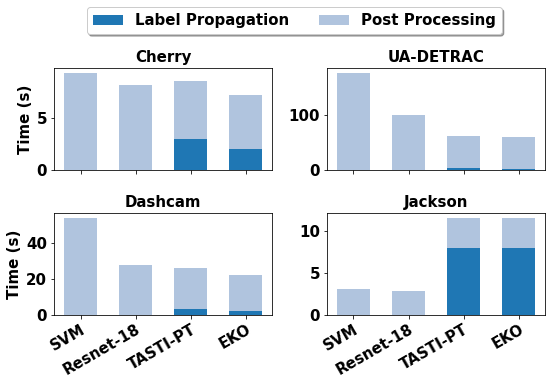

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

font = {
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=15)


x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'EKO']

x = np.arange(len(x_axis_names))


### we need to do subplots
rows = 2
columns = 2
fig_size = (8, 5)
fig, axes = plt.subplots(rows, columns, sharey = False, sharex=True, figsize=fig_size)


i = 0
j = 0
width = 0.6

axes[i][j].bar(x_axis_names, cherry_lp, width, label='Label Propagation')
axes[i][j].bar(x_axis_names, cherry_pp, width, bottom = cherry_lp, label='Post Processing', color = 'lightsteelblue')
axes[i][j].set_ylabel('Time (s)', weight = 'bold', size = 15)
#axes[i][j].set_ylim(0, 200)
#axes[i][j].set_yticks([0, 50, 100, 150, 200])

axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right',rotation_mode='anchor')
#plt.ylim(0, 2)
#plt.xticks(x, x_axis_names)
axes[i][j].set_title('Cherry', weight = 'bold', size = 15)


i = 0
j = 1
axes[i][j].bar(x_axis_names, detrac_lp, width, label='Label Propagation')
axes[i][j].bar(x_axis_names, detrac_pp, width, bottom = detrac_lp, label='Post Processing', color = 'lightsteelblue')
axes[i][j].set_title('UA-DETRAC', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


i = 1
j = 0
axes[i][j].bar(x_axis_names, dashcam_lp, width, label='Label Propagation')
axes[i][j].bar(x_axis_names, dashcam_pp, width, bottom = dashcam_lp, label='Post Processing', color = 'lightsteelblue')
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')
axes[i][j].set_ylabel('Time (s)', weight = 'bold', size = 15)

axes[i][j].set_title('Dashcam', weight = 'bold', size = 15)


i = 1
j = 1
axes[i][j].bar(x_axis_names, jackson_lp, width, label='Label Propagation')
axes[i][j].bar(x_axis_names, jackson_pp, width, bottom = jackson_lp, label='Post Processing', color = 'lightsteelblue')

axes[i][j].set_title('Jackson', weight = 'bold', size = 15)
axes[i][j].set_xticklabels(x_axis_names, rotation = 30, ha = 'right', rotation_mode='anchor')


plt.tight_layout()

plt.legend(loc='upper center', bbox_to_anchor=(-0.15, 3.1),
          fancybox=True, shadow=True, ncol=10)
#plt.legend()
plt.savefig('plots/query-execution-q1.png')
plt.show()

### OLD Graphs

In [ ]:
THR = 1 / 140


#### Q1
x_axis_names = ['SVM', 'Resnet-18', 'TASTI-PT', 'EKO']
cherry_q1_others = [0, 0, 4.2, 3.9]
cherry_q1_post = [3300 * THR, 2545 * THR, 1892 * THR, 1829 * THR]

#### Q2
cherry_q2_others = [0, 0, 4.2, 3.9]
cherry_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]

#### Q3
cherry_q3_others = [0, 0, 4.2, 3.9]
cherry_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
detrac_q1_others = [0, 0, 4.2, 3.9]
detrac_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
detrac_q2_others = [0, 0, 4.2, 3.9]
detrac_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
detrac_q3_others = [0, 0, 4.2, 3.9]
detrac_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
dashcam_q1_others = [0, 0, 4.2, 3.9]
dashcam_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
dashcam_q2_others = [0, 0, 4.2, 3.9]
dashcam_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
dashcam_q3_others = [0, 0, 4.2, 3.9]
dashcam_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q1
jackson_q1_others = [0, 0, 4.2, 3.9]
jackson_q1_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q2
jackson_q2_others = [0, 0, 4.2, 3.9]
jackson_q2_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]


#### Q3
jackson_q3_others = [0, 0, 4.2, 3.9]
jackson_q3_post = [1219 * THR, 886 * THR, 779 * THR, 778 * THR]



import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### we need to do subplots
rows = 1
columns = 3
i = 1
fig = plt.figure(figsize = (15,3))
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.ylabel('Time (s)')
plt.xticks(x, x_axis_names)
plt.title('Q1 -- Aggregate')


i = 2
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q2 -- Precision')



i = 3
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q3 -- Recall')




plt.xticks(x, x_axis_names)
plt.legend()
plt.show()



In [ ]:
### TODO: Need to include the YOLOv5 inference time for EKO -- this is pretty significant

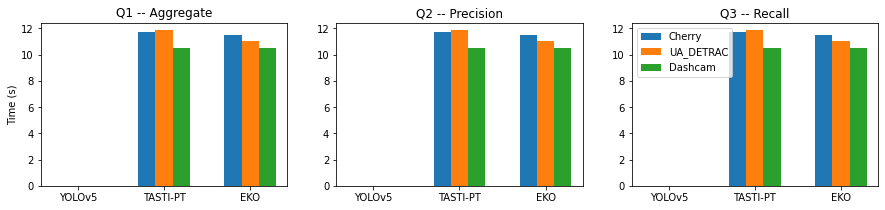

In [14]:
### generate the outcome graph first 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
### drawing function for the graph

#### Q1 values

x_axis_names = ['YOLOv5', 'TASTI-PT', 'EKO']
cherry_values = [0, 9.68, 9.5]
ua_values = [0, 61.25, 65.4]
da_values = [0, 3.3 + 21.47, 2.9 + 22.17]


##### Q2 values
cherry_values = [0, 4.48 + 7.14, 4.26 + 7.14]
ua_values = [0, 11.18, 12.94]
da_values = [0, 3.57 + 7.14, 3.4 + 7.14]

##### Q3 values
cherry_values = [0, 4.56 + 7.14, 4.32 + 7.14]
ua_values = [0, 11.84, 11.04]
da_values = [0, 3.4 + 7.14, 3.4 + 7.14]


x = np.arange(len(x_axis_names))
width = 0.2


### we need to do subplots
rows = 1
columns = 3
i = 1
fig = plt.figure(figsize = (15,3))
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.ylabel('Time (s)')
plt.xticks(x, x_axis_names)
plt.title('Q1 -- Aggregate')





i = 2
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q2 -- Precision')



i = 3
fig.add_subplot(rows, columns, i)
plt.bar(x - width, cherry_values, width, label = 'Cherry')
plt.bar(x, ua_values, width, label = 'UA_DETRAC')
plt.bar(x + width, da_values, width, label = 'Dashcam')
plt.xticks(x, x_axis_names)
plt.title('Q3 -- Recall')




plt.xticks(x, x_axis_names)
plt.legend()
plt.show()


In [15]:
cherry_values = [0, 9.68, 9.5]
ua_values = [0, 61.25, 65.4]
da_values = [0, 3.3 + 21.47, 2.9 + 22.17]


##### Q2 values
cherry_values2 = [0, 4.48 + 7.14, 4.26 + 7.14]
ua_values2 = [0, 11.18, 12.94]
da_values2 = [0, 3.57 + 7.14, 3.4 + 7.14]

##### Q3 values
cherry_values3 = [0, 4.56 + 7.14, 4.32 + 7.14]
ua_values3 = [0, 11.84, 11.04]
da_values3 = [0, 3.4 + 7.14, 3.4 + 7.14]

In [17]:
tmp = np.array([cherry_values, ua_values, da_values, cherry_values2, ua_values2, da_values2, cherry_values3, ua_values3, da_values3])
tmp.mean(axis = 0)

array([          0,      18.143,      18.654])

In [18]:
print('hello world')

hello world
